In [1]:
%matplotlib inline
import os, sys, glob, fnmatch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
DATA_DIR = '/Volumes/PFagrelius_Backup/sky_data/'

In [3]:
meta_dir = '/Users/parkerf/Research/SkyModel/BOSS_Sky/Analysis/MetaData/dark_meta_rich.npy'
Meta_Data = np.load(meta_dir)

In [4]:
def clean_spectrum(spectrum):
    neg = np.where(spectrum['SKY'] < 0)
    bad = np.where((np.isnan(spectrum['SKY'])) | (np.isinf(spectrum['SKY'])))
    spectrum['SKY'][neg] = 0
    spectrum['SKY'][bad] = 0
    
    return spectrum

In [36]:
#Get one random spectrum to check out
def get_spectrum():
    plate = np.random.choice(np.unique(Meta_Data['PLATE']),1)[0]
    print("plate: ",plate)
    PlateMeta = Meta_Data[Meta_Data['PLATE'] == plate]
    img = np.random.choice(np.unique(PlateMeta['IMG']),1)[0]
    ThisMeta = PlateMeta[PlateMeta['IMG'] == img]
    fiber = np.random.choice(np.unique(ThisMeta['FIB']),1)[0]
    spectra = ThisMeta[ThisMeta['FIB'] == fiber]
    SS = []
    GG = []
    xx = np.linspace(365, 1040, (1040-365)*100)
    for spec in spectra:
        specno = spec['SPECNO']
        data = np.load(DATA_DIR+'sky_flux/%s_calibrated_sky.npy' % str(plate))
        spectrum = data[specno]
        spectrum = clean_spectrum(spectrum)
        f = interp1d(spectrum['WAVE'], spectrum['SKY'], bounds_error=False, fill_value=0)
        g = interp1d(spectrum['WAVE'], spectrum['IVAR'], bounds_error=False, fill_value=0)
        sky = f(xx)
        ivar = g(xx)
        plt.plot(xx, sky)
        SS.append(sky)
        GG.append(ivar)
    SS = np.sum(SS, axis=0)
    GG = np.sum(GG, axis=0)
    #print(SS.shape)
    return xx, SS, GG, plate, img

In [67]:
wave, sky, ivar, plate, img = get_spectrum()
#plt.xlim([550,650])
#plt.ylim([0,5])

plate:  6045


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/PFagrelius_Backup/sky_data/sky_flux/6045_calibrated_sky.npy'

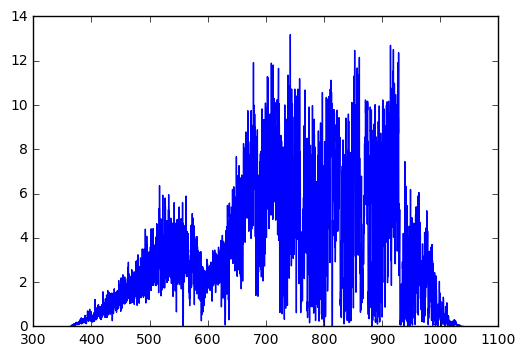

In [7]:
plt.plot(wave, ivar)

In [41]:
def mean_plate():
    plate = np.random.choice(np.unique(Meta_Data['PLATE']),1)[0]
    PlateMeta = Meta_Data[Meta_Data['PLATE'] == plate]
    img = np.random.choice(np.unique(PlateMeta['IMG']),1)[0]
    ThisMeta = PlateMeta[PlateMeta['IMG'] == img]
    print(plate, img)
    xx = np.linspace(365, 1040, (1040-365)*100)
    SKY_SPECTRA = []
    SKY_IVAR = []
    for fiber_num in np.unique(ThisMeta['FIB']):
        fiber_spectrum = []
        fiber_ivar = []
        spectra = ThisMeta[ThisMeta['FIB'] == fiber_num]
        for spec in spectra:
            specno = spec['SPECNO']
            data = np.load(DATA_DIR+'sky_flux/%s_calibrated_sky.npy' % str(plate))
            spectrum = data[specno]
            spectrum = clean_spectrum(spectrum)
            f = interp1d(spectrum['WAVE'], spectrum['SKY'], bounds_error=False, fill_value=0)
            g = interp1d(spectrum['WAVE'], spectrum['IVAR'], bounds_error=False, fill_value=0)
            sky = f(xx)
            ivar = g(xx)
            fiber_spectrum.append(sky)
            fiber_ivar.append(ivar)
        max_spectrum = np.maximum(fiber_spectrum[0], fiber_spectrum[1])
        Sky_ivar = np.array(fiber_ivar[0]).copy()
        fiber_ivar1 = np.array(fiber_ivar[1])
        Sky_ivar[np.where(max_spectrum == np.array(fiber_spectrum[1]))[0]] = fiber_ivar1[np.where(max_spectrum == np.array(fiber_spectrum[1]))[0]]
        SKY_SPECTRA.append(max_spectrum)
        SKY_IVAR.append(Sky_ivar)

    mean_spectrum = np.ma.average(SKY_SPECTRA, axis=0, weights=SKY_IVAR)
    
    return xx, mean_spectrum

In [9]:
wave, spectrum = mean_plate()

5188 133264


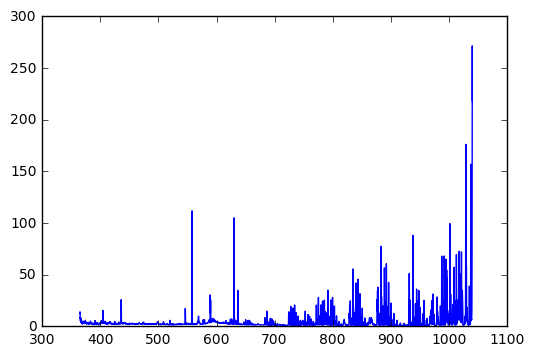

In [11]:
plt.plot(wave, spectrum)
#plt.xlim([550,700])
#plt.ylim([0,5])

In [64]:
def binned_cont(wave, spectrum, spacing):
    bins = np.linspace(365,1040,(1040-365)*spacing)
    min_values = []
    for i, w in enumerate(bins):
        if w < 1040.:
            section = np.where((wave>bins[i])&(wave<bins[i+1]))
            window = spectrum[section]
            m = np.ma.masked_array(window, mask=(window==0))
            ind = np.where(m==m.min())
            min_values.append(window[ind][0])
    f = interp1d(bins[:-1], min_values,bounds_error=False, fill_value="extrapolate")
    
    return f(wave)

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app


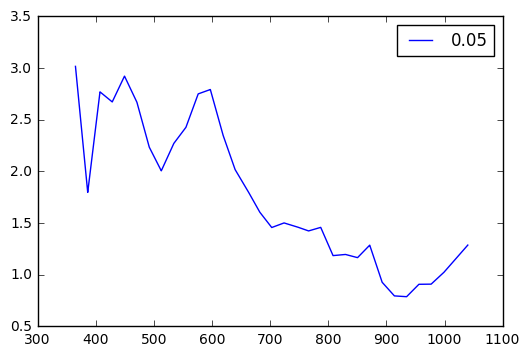

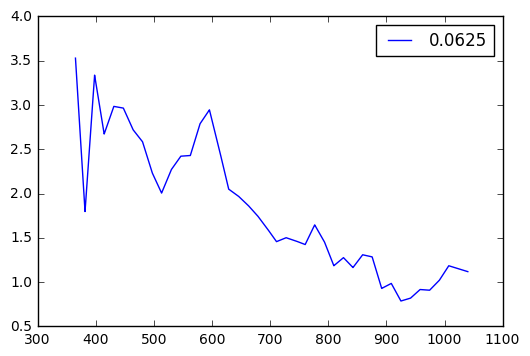

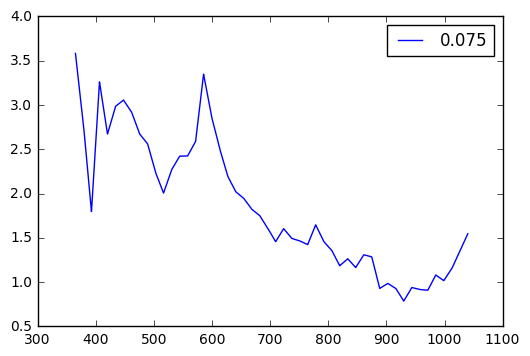

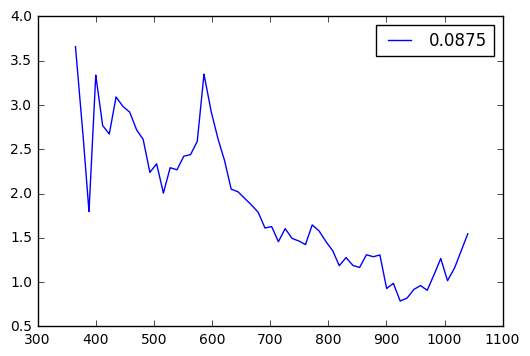

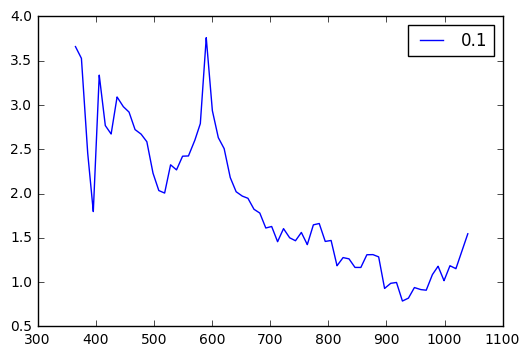

In [66]:
for x in np.linspace(0.05,.1,5):
    plt.figure()
    cont = binned_cont(wave, spectrum, x)
    plt.plot(wave, cont, label = x)
    plt.legend()

In [42]:
mean_spectra = []
for i in range(10):
    wave, spectrum = mean_plate()
    mean_spectra.append(spectrum)

4975 142790
4895 131259
4025 115969
4977 143384
4890 132462
6786 162816
6709 161899
5008 132659
4758 130373
4851 130251


/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app
/Users/parkerf/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:583: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


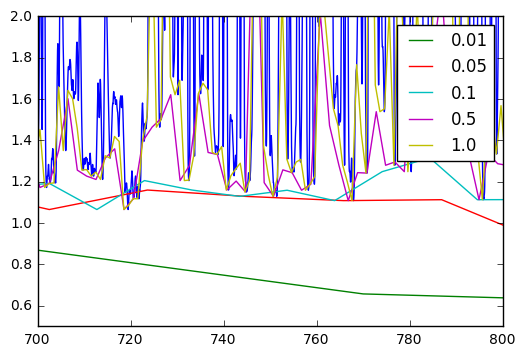

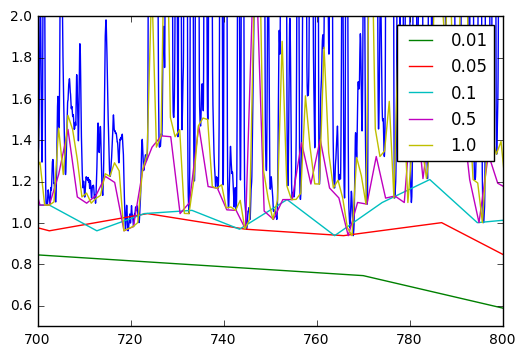

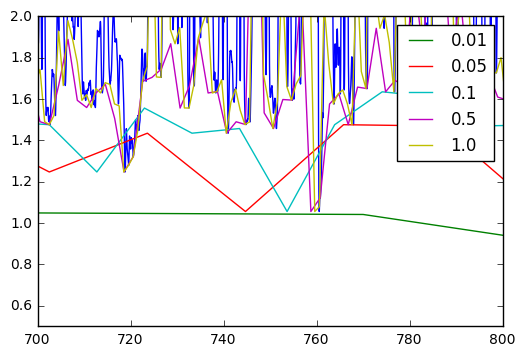

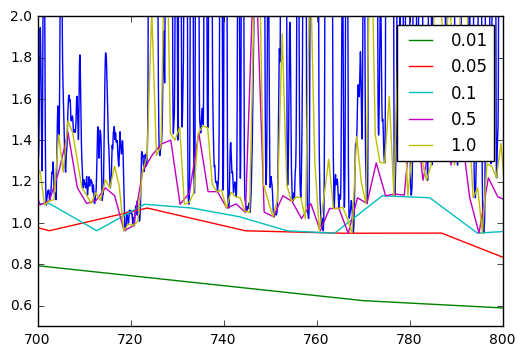

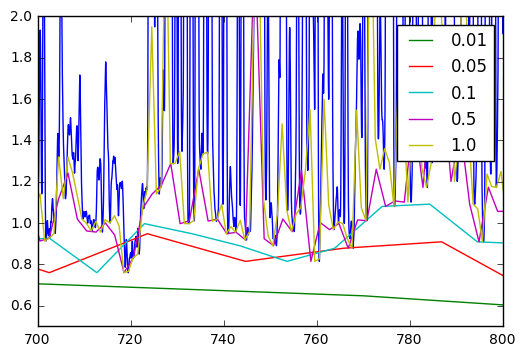

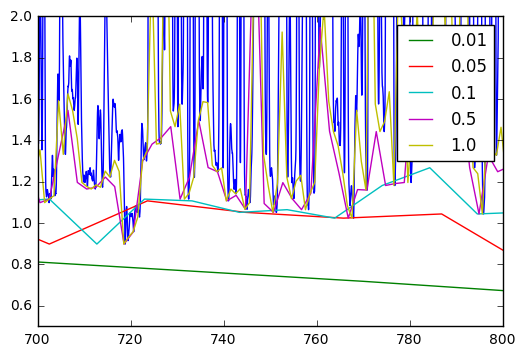

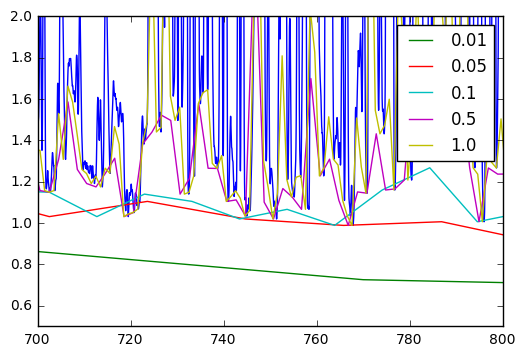

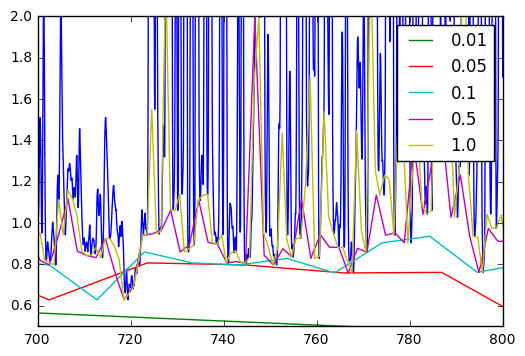

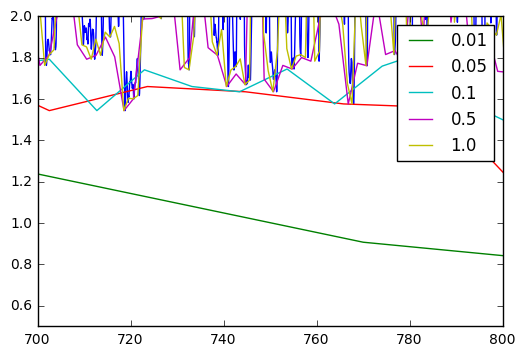

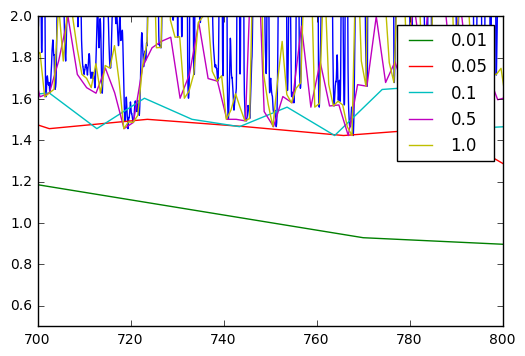

In [57]:
for spectrum in mean_spectra:
    plt.figure()
    plt.plot(wave, spectrum)
    for x in [.01, .05, 0.1,0.5,1.]:
        bins, cont = binned_cont(wave, spectrum, x)
        plt.plot(bins, cont, label = x)
        plt.legend()
        plt.ylim([0.5,2])
        plt.xlim([700,800])

### Compare to actual flux

plate:  4720
4720 130864
plate:  6039
6039 145109
plate:  6023
6023 144145
plate:  5003
5003 131586
plate:  6833
6833 160928
plate:  4994
4994 132304
plate:  6063
6063 145052
plate:  6723
6723 161820
plate:  6064
6064 144997
plate:  7031
7031 162876


OSError: [Errno 6] Device not configured

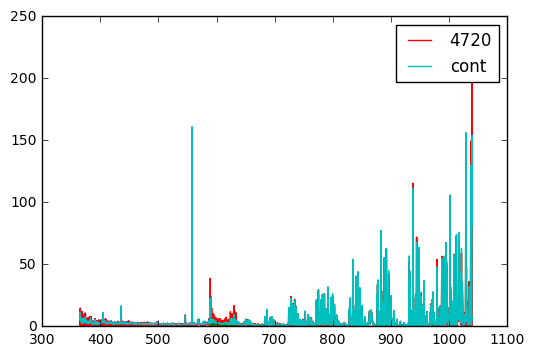

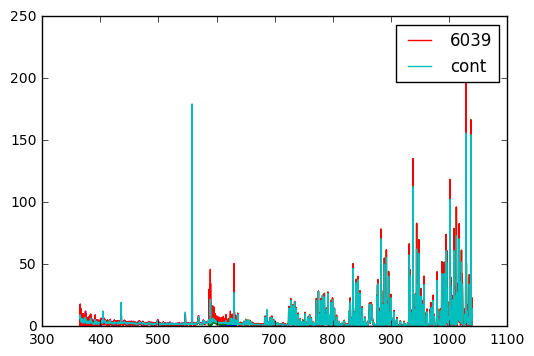

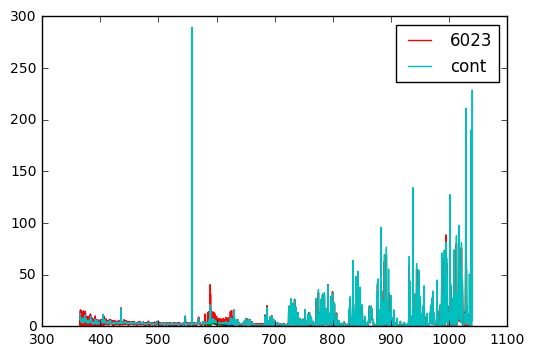

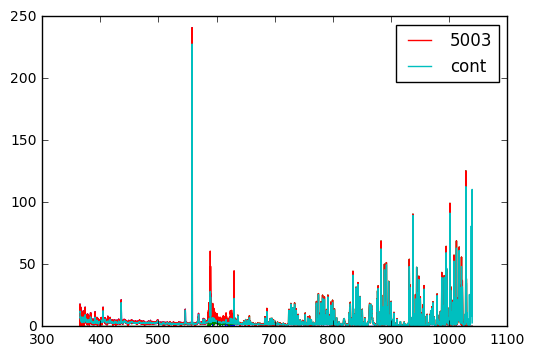

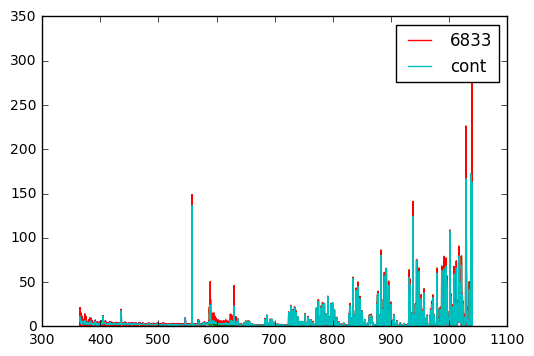

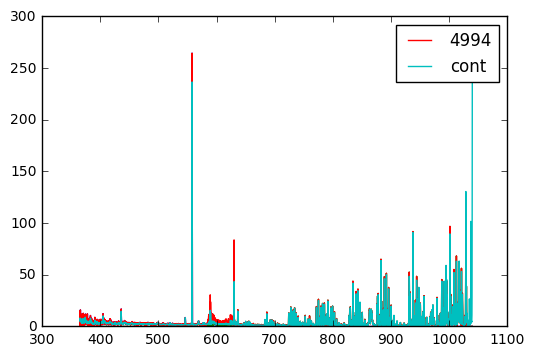

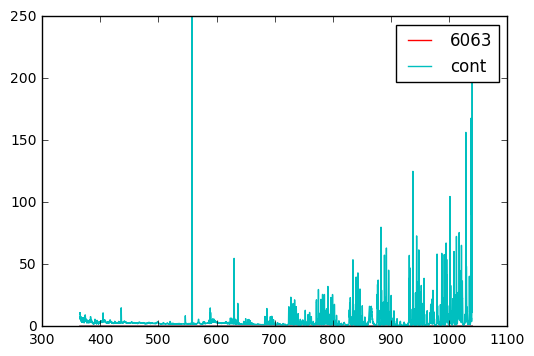

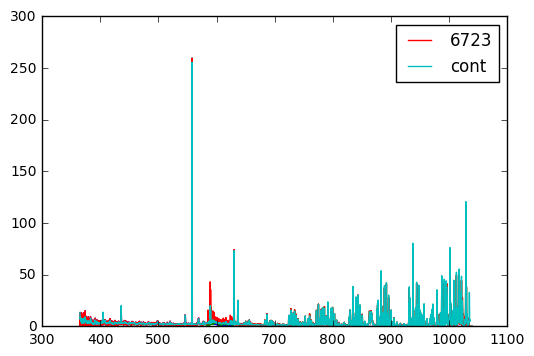

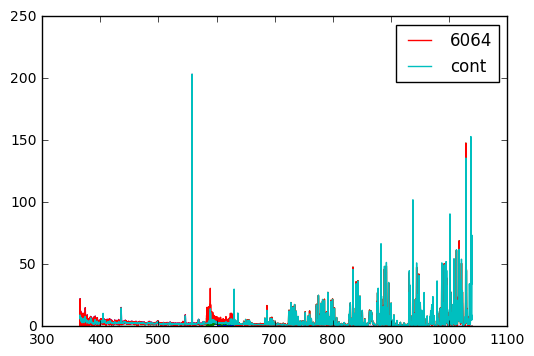

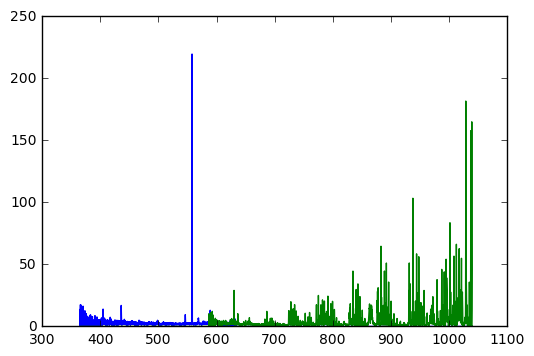

In [38]:
spacing = 0.02
for i in range(10):
    plt.figure()
    wave, sky, ivar, plate, img = get_spectrum()
    wave, mean_spectra = mean_plate(plate, img)
    plt.plot(wave, sky, label = plate)
    plt.plot(wave, mean_spectra, label = 'cont')
    plt.legend()